# Collocation 

This notebook solves the income fluctuations problem using collocation on the value function. Collocation is a dimensionality reduction technique which provides necessary efficiency gains when dealing with high-dimensional problems. With just ten asset grid points (on an unevenly spaced grid), we can obtain accurate solutions to the value function in less than one-tenth of the time relative to a "full" discretization of the state space (of course, this depends on the number of points, but compare this to the VFI notebook).

The notebook heavily uses the powerful BasisMatrices.jl library and follows the example therein for the Aiyagari model. Take a look at the [examples](https://github.com/QuantEcon/BasisMatrices.jl/blob/master/demo/examples.ipynb) in the documentation to get a better idea of how BasisMatrices.jl constructs basis matrices, evaluates approximated functions, etc.

In [1]:
include("rowenhorst_tauchen.jl") # include discretization functions (make sure it is in your working directory)

using Parameters, Plots, LinearAlgebra, BasisMatrices, SparseArrays, QuantEcon, Optim

Household = @with_kw (apoints, # asset grid
    amax,  # asset max
    bc, # borrowing constraint (must be weakly negative)
    agrid, # asset grid
    basis, # basis type
    bs, # basis matrix, not expanded
    expectation_basis, # expectation basis matrix
    transition_matrix, # transition matrix
    ygrid, # grid for income process
    nodes, # tensor product of agrid, ygrid
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    phi = 0.8, # disutility factor
    frisch = 0.5) # frisch elasticity for labor supply 





##NamedTuple_kw#253 (generic function with 2 methods)

### Constructing grids

The main difference relative to other notebooks (EGM, VFI) is that we need to do a bit more work in constructing the basis matrices (which we will use to approximate our desired function) and the grids.

In [2]:
function construct_household(bc = 0, apoints = 10, amax = 70,
        mean = 0, sd = 0.13, rho = 0.966, uncond_sd = sd/sqrt(1-rho^2), num_states = 7, order = 3, curve = 2)

    agrid = range(bc^(1/curve), stop = amax^(1/curve), length = apoints).^curve

    transition_matrix, ygrid = rowenhorst(mean, uncond_sd, rho, num_states)

    a_basis = Basis(SplineParams(agrid, 0 , order))
    y_basis = Basis(SplineParams(ygrid, 0 , 1))

    basis = Basis(a_basis, y_basis)

    s, (agrid, ygrid) = nodes(basis)

    Ns, Na, Ny = size(s, 1), size(agrid, 1), size(ygrid, 1)
    
    @assert Ny == num_states

    # compute expectations matrix
    
    bs = BasisMatrix(basis, Direct())
    bs_expanded = convert(Expanded, bs).vals[1]
    expectation_basis = kron(transition_matrix, sparse(I, Na, Na))*bs_expanded

    hh = Household(apoints = apoints, amax = amax, bc = bc, agrid = agrid, basis = basis, bs = bs, expectation_basis = expectation_basis,
        transition_matrix = transition_matrix, ygrid = ygrid, nodes = s)

    return hh
    
end

hh = construct_household()




(apoints = 10, amax = 70, bc = 0, agrid = [0.0, 0.28806584362139914, 1.4403292181069958, 4.032921810699588, 8.353909465020577, 14.403292181069958, 22.18106995884774, 31.687242798353907, 42.92181069958847, 55.88477366255143, 65.10288065843622, 70.0], basis = 2 dimensional Basis on the hypercube formed by (0.0, 0.25738376293233367) × (70.0, 3.022594266947119).
Basis families are Spline × Spline
, bs = BasisMatrix{Direct} of order [0 0], expectation_basis = 
  [1 ,  1]  =  0.902238
  [2 ,  1]  =  0.26733
  [13,  1]  =  0.0156033
  [14,  1]  =  0.0046232
  [25,  1]  =  0.000269843
  [26,  1]  =  7.99536e-5
  [37,  1]  =  4.66667e-6
  [38,  1]  =  1.38272e-6
  [49,  1]  =  8.07054e-8
  [50,  1]  =  2.39127e-8
  [61,  1]  =  1.39572e-9
  [62,  1]  =  4.13546e-10
  ⋮
  [36, 84]  =  8.07054e-8
  [46, 84]  =  2.81441e-10
  [47, 84]  =  1.38272e-6
  [48, 84]  =  4.66667e-6
  [58, 84]  =  1.62739e-8
  [59, 84]  =  7.99536e-5
  [60, 84]  =  0.000269843
  [70, 84]  =  9.41014e-7
  [71, 84]  =  0.00

### Approximating the value function

We now use the basis we constructed to approximate the value function. Note, however, that the value function is not the only function we could approximate. We could have also approximated its derivative, or the consumption policy function itself and then used the endogenous grid method, or the envelope condition method (Maliar and Maliar, 2011). In many cases, this is desirable because it avoids root-finding. Indeed, this is what the endogenous grid method does indirectly -- it interpolates the current consumption function on the future grid. This is equivalent to forming a linear basis on the current grid, and then evaluating that function on the future asset grid. 

In [3]:
function utility(gamma, nodes, anext, r, w)
    c = (1 + r).*nodes[:, 1] + w.*nodes[:, 2] - anext
    u_mat = similar(c)
    fill!(u_mat, 0)
    for cc=1:length(c)
        if c[cc] <= 0
            u_mat[cc] = -Inf
        else
            u_mat[cc] = u(c[cc], gamma)
        end
    end
    return u_mat
end

function utility_labor(hh, nodes, anext, r, w)
    @unpack gamma, phi, frisch = hh
    u_mat = similar(anext)
    c(l, i) = max((1 + r).*nodes[i, 1] + w.*nodes[i, 2].*l - anext[i], 0)
    for i in eachindex(anext)
        res = optimize(l -> -u(c(l, i), gamma) + v(l, phi, frisch), 0.0, 1.0)
        u_mat[i] = -res.minimum
    end
    return u_mat
end

function v(l, phi, frisch)
   return phi*l^(1+frisch)/(1+frisch) 
end

function u(c, gamma)
    if gamma == 1
        return log.(c)
    else
        return @. c^(1-gamma)/(1-gamma) 
    end
end


function value(hh; anext, r, w, ce, labor = true)
    @unpack gamma, nodes, basis, beta = hh
    
    # flow payoff
    if labor
        u = utility_labor(hh, nodes, anext, r, w)
    else 
        u = utility(gamma, nodes, anext, r, w)
    end
    
    # Basis matrix for continuation value
    ve = reshape(funeval(ce, basis, [anext nodes[:,2]]), (:,))

    # Compute value
    v1 = u + beta.*ve
    
    return v1
end

value(hh, anext = ones(84).*10, r=1, w=1, ce = ones(84)*.100)

84-element Array{Float64,1}:
 -Inf
 -Inf
 -Inf
 -Inf
   2.001303270328464
   3.0322083756354807
   3.634955593381881
   4.0753328923737255
   4.426673627678971
   4.720710925600278
   4.887204957154127
   4.96553445449773
 -Inf
   ⋮
 -Inf
 -Inf
 -Inf
 -Inf
   2.0413663816377072
   3.034348620543369
   3.6353092955245607
   4.075427381997017
   4.4267065695645185
   4.720724561691087
   4.887213232345623
   4.965540996749247

In [4]:
function opt_value(hh, r, w, ce, c1)
    @unpack nodes, bc, expectation_basis = hh
    
    # solve maximization problem
    lower_bound = zeros(size(nodes, 1)) .+ bc
    upper_bound = (1 + r).*nodes[:, 1] + w.*nodes[:, 2]
    f(anext) = value(hh, anext = anext, r = r, w = w, ce = ce)
    
    ap, v1 = golden_method(f, lower_bound, upper_bound)
    
    # compute expected value function
    ve = expectation_basis*c1

    return v1, ve, ap
end

opt_value (generic function with 1 method)

In [5]:
opt_value(hh, 0.1, 0.2, zeros(84), zeros(84))

([-3.4999583156586356, -1.1470451177546348, 0.460199753104993, 1.4898021218824087, 2.218039900055158, 2.7627670018048733, 3.1945494052579204, 3.5512243459831994, 3.8546902851336196, 4.118602137882289  …  0.4860235015802429, 1.4911114987553216, 2.2181879891283383, 2.762795911276077, 3.194557321499914, 3.55122706131783, 3.8546913776948464, 4.118602632877011, 4.271279291077227, 4.343805673885664], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.05098666251171e-17, 8.067314470338119e-17, 4.704727866551496e-17, 4.3342166112562015e-16, 3.4438787124318015e-15, 1.1386249748141645e-14, 1.164945072827501e-14, 1.5069064033614774e-14, 2.113050552766984e-14, 4.8571845688414045e-14  …  3.786184053132681e-17, 3.1340640983121863e-16, 4.59854425616658e-15, 4.1150205099899e-15, 4.792651626838114e-15, 1.4801653323684583e-14, 2.0381288272964878e-14, 4.68961764522278e-14, 9.103811619914212e-14, 1.0085916136239334e-13])

In [6]:
function coeff(hh; r = 0.01, w = 0.5, ce, c1)
    @unpack nodes, bs = hh
    # Compute values
    v1, ve, ap = opt_value(hh, r, w, ce, c1)
    bs_expanded = convert(Expanded, bs).vals[1]
    # Update coefficients
    c1 = bs_expanded\v1
    ce = bs_expanded\ve

    return c1, ce
end

function vfi(hh; tol=1e-8, maxiter = 10000)
    
    @unpack nodes = hh
    
    ce_old = zeros(length(nodes[:,1]))
    c1_old = zeros(length(nodes[:,1]))
    
    for i=1:maxiter
        c1, ce = coeff(hh, ce = ce_old, c1 = c1_old)
        dc = norm([c1, ce] - [c1_old, ce_old], Inf)
        if dc < tol 
            println("Converged in $(i) iterations.")
            return c1, ce
        else ce_old = ce; c1_old = c1;
        end
    end
    error("no convergence!")
end

vfi (generic function with 1 method)

In [7]:
c1, ce  = vfi(hh)

r = 0.01; w = 0.5;

v1, _ , ap = opt_value(hh, r, w, ce, c1)

Converged in 2073 iterations.


([-90.58960120519852, -88.85113410875769, -83.46758680409236, -74.54257897432467, -63.70080244142703, -52.35843337840773, -41.10691902491646, -30.213188056394017, -19.802947314166392, -9.93125489138794  …  -41.3453968890574, -38.80925430791116, -34.85146431803897, -29.75758971658875, -23.813460784039766, -17.264445232407855, -10.297674411663207, -3.1168029710419067, 1.561191366881131, 3.9231176507698384], [-89.80197308416392, -88.1143046043113, -82.86380705087205, -74.1054373566485, -63.404125161635015, -52.16081489671696, -40.97578738249659, -30.126082520491913, -19.744919309531028, -9.892440318773183  …  -42.182463932028135, -39.592022315538614, -35.55916963173621, -30.37894861267041, -24.34373788506842, -17.704107299223093, -10.647871302366676, -3.3817443200849624, 1.3436898584384913, 3.726736784983552], [5.4118443831044706e-15, 0.2122630359010815, 1.264939779196602, 3.7605029421070753, 7.986259059266225, 13.94105839778837, 21.621733122907955, 31.02522769839432, 42.148666487126405, 

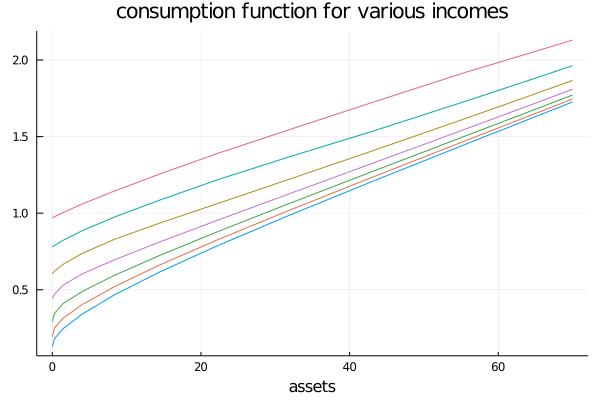

In [8]:
# for the case without labor just set labor = false in the value function and set l = 1 below

l = similar(ap)
c(l, i) = max((1 + r).*hh.nodes[i, 1] + w.*hh.nodes[i, 2].*l - ap[i], 0)
for i in eachindex(ap)
    res = optimize(l -> -u(c(l, i), hh.gamma) + v(l, hh.phi, hh.frisch), 0.0, 1.0)
    l[i] = res.minimizer
end

consumption = (1 + r).*hh.nodes[:, 1] + w.*hh.nodes[:, 2].*l - ap

consumption = reshape(consumption, (:,length(hh.ygrid)))


plot(hh.agrid, consumption, legend = false, title = "consumption function for various incomes", xlabel = "assets" )

### Final Remarks

In the algorithm above, we did not exploit a form of the Howard improvement step. Because the derivative of the value function can be found in closed form with collocation, we can transform the iteration on the coefficients as a root finding problem using Newton-Raphson methods.

Although collocation is a valuable dimensionality reduction technique, the state space still increases exponentially in the number of state variables. BasisMatrices.jl has the tools to construct Smolyak grids, which make the number of nodes grow at a polynomial rate. This is necessary when dealing with models with a very large state space, such as international business cycle models.